<h1><center> Phase II Model Building - Credit Prediction </center></h1>
<center>  Wei-Ting Lin (Ivy) - s3698773 </center>
<center> 2019-06-09</center>

--- 

# Overview

The objective of Phase II Model Building is to find the best machine learning model to predict credit quality 
using German credit data set, sourced from the UCI Machine Learning Repository (Hofmann H., 1994). 

The report is organized as follows:
* Methodology 
* Data Preparation 
* Model Selection & Evaluation Strategy
* Hyperparameter Tuning
* Performance Evaluation
* Limitations 
* Conclusion


## Methodology

We will use the powerful scikit-learn Python package for modelling task. The following binary classifiers are selected to predict the target feature: K-Nearest Neighbors (KNN), Decision trees (DT) and Naive Bayes (NB). 

First of all, we load the full dataset cleaned from Phase I, and also make sure there is no missing value in the data set, since most machine learning algorithms cannot handle missing values. 

Our modelling strategy begins with transformation. This transformation includes encoding categorical descriptive features into numeric and then scale the descriptive features. We split the data set into training and test sets with a 70:30 ratio. Before model fitting, we select the best features using the Random Forest Importance method inside a pipeline. We consider 10, 20, 30 and the full set of features (with 59 features) after encoding of categorical features.

Since this credit dataset requires the use of a cost matrix, we implement a customized cost score function for our performance metrics. Using feature selection together with hyperparameter search inside a single pipeline, we conduct a 5-fold stratified cross-validation to fine-tune hyperparameters of each classifier using the pre-defined `cost_score` function.

We build each model using parallel processing. Once the best model is identified for each of the three classifiers, we conduct a 10-fold cross-validation on the test data and perform a pair-wised t-test to see if the difference in the performance is statistically significant. Also, we compare the classifiers with their precision scores on the test data. 


# Data Preparation

###  Loading Data and Libararies

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
credit = pd.read_csv('german.data', sep = ' ')

In [3]:
credit.columns = ['status_of_existing_checking_account', 'duration_month', 'credit_history', 'purpose',
                  'credit_amount','savings_account','present_employment_since','IRPDI','personal_status_and_sex',
                 'other_debtors','present_residence_since','property', 'age', 'other_installment_plans',
                  'housing','number_of_existing_credits','job','liable_ppl_num','telephone','foreign_worker',
                  'credit_classification']

In [4]:
credit.head()

,status_of_existing_checking_account,duration_month,credit_history,purpose,credit_amount,savings_account,present_employment_since,IRPDI,personal_status_and_sex,other_debtors,...,property,age,other_installment_plans,housing,number_of_existing_credits,job,liable_ppl_num,telephone,foreign_worker,credit_classification
0,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
1,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
2,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
3,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2
4,A14,36,A32,A46,9055,A65,A73,2,A93,A101,...,A124,35,A143,A153,1,A172,2,A192,A201,1


In [5]:
#check the shape of data 
credit.shape

(999, 21)

The dataset contains 21 variables and 999 observations.

In [6]:
# check the data type. 
credit.dtypes

status_of_existing_checking_account    object
duration_month                          int64
credit_history                         object
purpose                                object
credit_amount                           int64
savings_account                        object
present_employment_since               object
IRPDI                                   int64
personal_status_and_sex                object
other_debtors                          object
present_residence_since                 int64
property                               object
age                                     int64
other_installment_plans                object
housing                                object
number_of_existing_credits              int64
job                                    object
liable_ppl_num                          int64
telephone                              object
foreign_worker                         object
credit_classification                   int64
dtype: object

The data set contains 13 objects, 7 numerical features with 1 binary target variable. 

## Check for Missing Value

There is no missing value in this data set. 

In [7]:
#check for missing value 
credit.isnull().sum()

status_of_existing_checking_account    0
duration_month                         0
credit_history                         0
purpose                                0
credit_amount                          0
savings_account                        0
present_employment_since               0
IRPDI                                  0
personal_status_and_sex                0
other_debtors                          0
present_residence_since                0
property                               0
age                                    0
other_installment_plans                0
housing                                0
number_of_existing_credits             0
job                                    0
liable_ppl_num                         0
telephone                              0
foreign_worker                         0
credit_classification                  0
dtype: int64

## Statistical Summary

According to Table 1, there's no `NaN` or extreme values. 

In [8]:
# statistical summury of the data 
display(HTML('<b>Table 1: Summary of continuous features</b>')) 
display(credit.describe(include = 'int'))
display(HTML('<b>Table 2: Summary of categorical features</b>'))
display(credit.describe(include = 'object'))

,duration_month,credit_amount,IRPDI,present_residence_since,age,number_of_existing_credits,liable_ppl_num,credit_classification
count,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000
mean,20.917918,3273.362362,2.971972,2.843844,35.514515,1.406406,1.155155,1.300300
std,12.055619,2823.365811,1.118802,1.103665,11.337487,0.577639,0.362234,0.458618
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000,1.000000
25%,12.000000,1368.500000,2.000000,2.000000,27.000000,1.000000,1.000000,1.000000
50%,18.000000,2320.000000,3.000000,3.000000,33.000000,1.000000,1.000000,1.000000
75%,24.000000,3972.500000,4.000000,4.000000,42.000000,2.000000,1.000000,2.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000,2.000000


,status_of_existing_checking_account,credit_history,purpose,savings_account,present_employment_since,personal_status_and_sex,other_debtors,property,other_installment_plans,housing,job,telephone,foreign_worker
count,999,999,999,999,999,999,999,999,999,999,999,999,999
unique,4,5,10,5,5,4,3,4,3,3,4,2,2
top,A14,A32,A43,A61,A73,A93,A101,A123,A143,A152,A173,A191,A201
freq,394,530,279,603,339,547,906,332,813,712,629,596,962


## Encode Categorical Features 
Here, we encode all categorical features before modelling into a set of numerical features.

### Encoding the Target Feature
For the ease of modelling task, The target feature: "credit_classification" was set independent from the full dataset and call it "target". The rest of the descriptive features are assign to "Data_unscaled", as we will scale the it later.

In [9]:
Data = credit.drop(columns = 'credit_classification')

target = credit['credit_classification']


First of all, let's tally the instances in target variable.
* According to the data data set: 1 = Good, 2 = Bad credit. 
* We have 699 good credit and 300 bad credit. The portion is slightly inbalance, but it shouldn't be a big problem. 

In [10]:
target.value_counts()

1    699
2    300
Name: credit_classification, dtype: int64

For later model evaluation,we need the positive instance to be encoded as 1 and the negative one to be encoded as 0 for binary classification. 

In [11]:
target = pd.Series(target).replace({2: 0}).values
np.unique(target, return_counts = True)

(array([0, 1]), array([300, 699]))

### Encoding Descriptive Features

#### Nominal descriptive features in this data set are : 
* status_of_existing_checking_account
* credit_history
* purpose
* Savings account/bonds
* personal_status_and_sex
* other_debtors
* other_installment_plans
* housing
* job
* telephone
* foreign_worker

#### Ordinal descriptive features in this data set are : 
* present_employment_since
* property

###  Encode categorical descriptive features using One-Hot-Encoding
Since there are only 2 ordinal features,it would not make much difference if we use integer encoding for ordinal features separately in terms of dimension. Let's just use One-Hot-Encoding for all the categorial descriptive features. 

In [12]:
cat_cols = ['status_of_existing_checking_account', 'credit_history', 'purpose',
                 'savings_account','present_employment_since','personal_status_and_sex',
                 'other_debtors','property','other_installment_plans',
                  'housing','job','telephone','foreign_worker']

#For each two-level categorical variable,
# drop_first option is set to encode the variable into a single column of 0 or 1.
for col in cat_cols:
    if(len(Data[col].unique())==2):
        Data[col]= pd.get_dummies(Data[col], drop_first= True)

#encode the rest of the categorical data.      
Data = pd.get_dummies(Data)

Data.head(5)


,duration_month,credit_amount,IRPDI,present_residence_since,age,number_of_existing_credits,liable_ppl_num,telephone,foreign_worker,status_of_existing_checking_account_A11,...,other_installment_plans_A141,other_installment_plans_A142,other_installment_plans_A143,housing_A151,housing_A152,housing_A153,job_A171,job_A172,job_A173,job_A174
0,48,5951,2,2,22,1,1,0,0,0,...,0,0,1,0,1,0,0,0,1,0
1,12,2096,2,3,49,1,2,0,0,0,...,0,0,1,0,1,0,0,1,0,0
2,42,7882,2,4,45,1,2,0,0,1,...,0,0,1,0,0,1,0,0,1,0
3,24,4870,3,4,53,2,2,0,0,1,...,0,0,1,0,0,1,0,0,1,0
4,36,9055,2,4,35,1,2,1,0,0,...,0,0,1,0,0,1,0,1,0,0


### Scale Descriptive Features 
Here, we use Min-Max Scaling method to scale the descriptive features between 0 and 1. 
Min-Max scaler is chosen to normalize data since we will use KNN classifier, which is a distance-based algorithm. 

In [13]:
from sklearn import preprocessing 

#make a copy to keep the record of column names
Data_df = Data.copy()

Data = preprocessing.MinMaxScaler().fit_transform(Data)

Take a look at the data after encoding and scaling 

In [14]:
pd.DataFrame(Data, columns = Data_df.columns).sample(n=5, random_state = 23664)

,duration_month,credit_amount,IRPDI,present_residence_since,age,number_of_existing_credits,liable_ppl_num,telephone,foreign_worker,status_of_existing_checking_account_A11,...,other_installment_plans_A141,other_installment_plans_A142,other_installment_plans_A143,housing_A151,housing_A152,housing_A153,job_A171,job_A172,job_A173,job_A174
374,0.647059,0.409101,0.333333,1.000000,0.321429,0.000000,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
886,0.647059,0.848575,0.333333,0.333333,0.071429,0.000000,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
862,0.338235,0.235281,1.000000,0.333333,0.232143,0.333333,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
867,0.470588,0.393914,0.666667,0.333333,0.321429,0.333333,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
10,0.647059,0.223286,0.666667,1.000000,0.089286,0.000000,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


### Feature Selection & Ranking 

Let's have a look at the most important 10 features selected by Random Forest Importance (RFI) in the full dataset. During the hyperparameter tuning stage, we will search over 10,20 ,30, and the full features to decide the number of features that works best with each classifier.

In [15]:
from sklearn.ensemble import RandomForestClassifier

num_features = 10 
model_rfi = RandomForestClassifier(n_estimators = 100, random_state= 999)
model_rfi.fit(Data,target)
#sort the features by importance
fs_indice_rfi = np.argsort(model_rfi.feature_importances_)[::-1][0:num_features] 

best_features_rfi = Data_df.columns[fs_indice_rfi].values
best_features_rfi

array(['credit_amount', 'age', 'duration_month',
       'status_of_existing_checking_account_A14',
       'status_of_existing_checking_account_A11', 'IRPDI',
       'present_residence_since', 'credit_history_A34',
       'savings_account_A61', 'number_of_existing_credits'], dtype=object)

In [16]:
feature_importances_rfi = model_rfi.feature_importances_[fs_indice_rfi]
feature_importances_rfi

array([0.09991187, 0.08123932, 0.07880471, 0.05439587, 0.03779626,
       0.03533492, 0.03290916, 0.0230829 , 0.0202617 , 0.01808866])

Visualization of feature importance 

In [17]:
import altair as alt 
alt.renderers.enable('notebook')
# function to plot feature importance 
def barplot_imp(best_features, scores, method_name , color):
    i = 1
    df = pd.DataFrame({'Feature': best_features,
                     'Scores' :  scores})
    chart = alt.Chart(df,
                      width= 500,
                      title = 'Figure' + str(i) +': '+ method_name + 'Feature Importance').mark_bar(color = color).encode(
        alt.X('Feature', title = 'Feature', sort = None, axis = alt.AxisConfig(labelAngle = 45)),
        alt.Y('Scores', title = 'Scores')
    )
    i = i+1
    return chart 

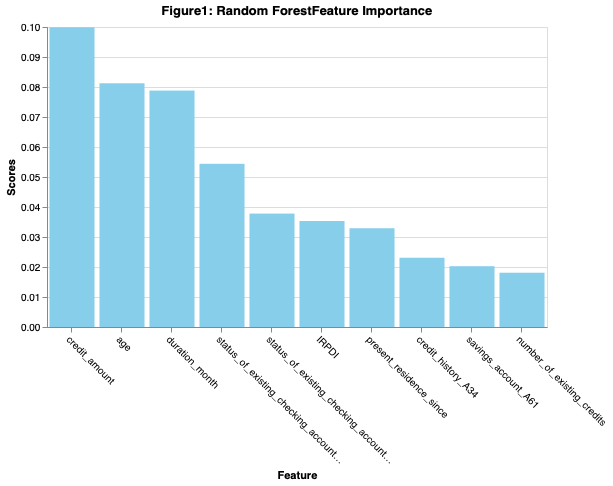

In [18]:
barplot_imp(best_features_rfi, feature_importances_rfi, 'Random Forest', 'skyblue')

According to Figure 1, credit amount, age and duration are the most important features. 

## Train & Test Data Spliting 
Spliting data into train and test set with 70/30 ratio and stratifing method.

In [19]:
from sklearn.model_selection import train_test_split

D_train ,D_test,t_train, t_test = train_test_split(Data, target,
                                                     test_size = 0.3, random_state = 999, 
                                                     stratify = target)
print( D_train.shape , D_test.shape )


(699, 59) (300, 59)


# Model Selection & Evaluation Strategy

### Model Selection
This data set is a binary classification task, we choose Decision Tree, Random Forest and K Nearest Neighbours classifiers as our candidate models. 

### Evaluation Strategy
We will train and tune our models on training sets, and we will test them with test set.
For each model, we will use 5-fold stratified cross-validation for hyperparameter tuning.    
As suggested by the data source (Hofmann 1994), this credit dataset requires use of a cost matrix (Table 3).
That means mis-classifying a bad customer as good is 5 times worse than classifying a customer as bad when they are actually good. 

                                               Table 3: cost matrix
|  cm  |   0  |  1   |
|------|------|------|
|   0  |   0  |  5   | 
|   1  |   1  |  0   |    

        
                                                (1 = Good, 0 = Bad) 
                    (The rows represent the actual classification and the columns the predicted classification.)


In [20]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import  make_scorer

cv_method = StratifiedKFold(n_splits = 5, random_state= 43 )

#define scoring strategy based on the cost matrix 
def cost_score_func(t_test , t_pre ):
    cm = confusion_matrix(t_test, t_pre)
    cost_matrix = np.array([[0,5],[1,0]])
    total_cost = np.multiply(cm, cost_matrix).sum()
    return total_cost

cost_score = make_scorer(cost_score_func, greater_is_better = False)  

The `cost_score_fun` returns postive numeric score, the lower the cost, the better the model is; while in `cost_score` we defined `greater_is_better = False`, which will return the same score but in negative value; thus, the score would  be the higher the better. We shall use `cost_score` for our performance metrics.

# Hyperparameter Tuning 

## K-Nearest Neighbors

Adopting `Pipeline`, we stack feature selection and grid search for KNN hyperparameter tuning via cross-validation.

The KNN hyperparameters are as follows:
* number of neighbors (`n_neighbors`) 
* the distance metric `p`.

For feature selection, we use Random Forest Importance (RFI) method with 100 estimators. In order to make the function reusable, we define the custom `RFIFeatureSelector()` class below to pass in RFI as a to the pipeline.

In [21]:
from sklearn.base import BaseEstimator, TransformerMixin

# custom function for RFI feature selection inside a pipeline
# here we use n_estimators=100
class RFIFeatureSelector(BaseEstimator, TransformerMixin):
    
    # class constructor 
    def __init__(self, n_features_=10):
        self.n_features_ = n_features_
        self.fs_indices_ = None

    # override the fit function
    def fit(self, X, y):
        from sklearn.ensemble import RandomForestClassifier
        from numpy import argsort
        model_rfi = RandomForestClassifier(n_estimators=100)
        model_rfi.fit(X, y)
        self.fs_indices_ = argsort(model_rfi.feature_importances_)[::-1][0:self.n_features_] 
        return self 
    
    # override the transform function
    def transform(self, X, y=None):
        return X[:, self.fs_indices_]

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

pipe_KNN = Pipeline(steps=[('rfi_fs', RFIFeatureSelector()), 
                           ('knn', KNeighborsClassifier())])

params_pipe_KNN = {'rfi_fs__n_features_': [10, 20, 30, Data.shape[1]],
                   'knn__n_neighbors': [1, 5, 10, 20, 40, 60],
                   'knn__p': [1, 2]}

gs_pipe_KNN = GridSearchCV(estimator=pipe_KNN, 
                           param_grid=params_pipe_KNN, 
                           cv=cv_method,
                           refit=True,
                           n_jobs=-2,
                           scoring= cost_score,
                           verbose=1) 

In [23]:
gs_pipe_KNN.fit(D_train, t_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-2)]: Done 194 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-2)]: Done 240 out of 240 | elapsed:   13.6s finished
/Users/ivylin/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=43, shuffle=False),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('rfi_fs',
                                        RFIFeatureSelector(n_features_=10)),
                                       ('knn',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
                                                             n_jobs=None,
                                                             n_neighbors=5, p=2,
                                                             weights='uniform'))],
                                verbose=False),
             iid='warn', n_jobs=-2,
             param_g

In [24]:
gs_pipe_KNN.best_params_

{'knn__n_neighbors': 10, 'knn__p': 2, 'rfi_fs__n_features_': 10}

In [25]:
gs_pipe_KNN.best_score_

-133.78969957081546

The optimal KNN model has cost metrix score of -133. The best performing KNN selected 10 features with 10 nearest neighbors and p = 2. We will check the other combinations of hyper-parameters to see if the difference is rather significant or not. 

In [26]:
# custom function to format the search results as a Pandas data frame
def get_search_results(gs):

    def model_result(scores, params):
        scores = {'mean_score': np.mean(scores),
             'std_score': np.std(scores),
             'min_score': np.min(scores),
             'max_score': np.max(scores)}
        return pd.Series({**params,**scores})

    models = []
    scores = []

    for i in range(gs.n_splits_):
        key = f"split{i}_test_score"
        r = gs.cv_results_[key]        
        scores.append(r.reshape(-1,1))

    all_scores = np.hstack(scores)
    for p, s in zip(gs.cv_results_['params'], all_scores):
        models.append((model_result(s, p)))

    pipe_results = pd.concat(models, axis=1).T.sort_values(['mean_score'], ascending=False)

    columns_first = ['mean_score', 'std_score', 'max_score', 'min_score']
    columns = columns_first + [c for c in pipe_results.columns if c not in columns_first]

    return pipe_results[columns]

In [27]:
results_KNN = get_search_results(gs_pipe_KNN)
results_KNN.head()

,mean_score,std_score,max_score,min_score,knn__n_neighbors,knn__p,rfi_fs__n_features_
20,-133.8,9.806121,-116.0,-144.0,10.0,2.0,10.0
16,-134.4,10.556515,-120.0,-148.0,10.0,1.0,10.0
21,-137.2,10.533755,-120.0,-151.0,10.0,2.0,20.0
36,-137.8,9.826495,-131.0,-157.0,40.0,2.0,10.0
32,-140.4,8.064738,-129.0,-154.0,40.0,1.0,10.0


The difference between the hyperparameter combinations is not much when 10 features were selected.
The visualization below shows the results of the grid search corresponding to 10 selected features.

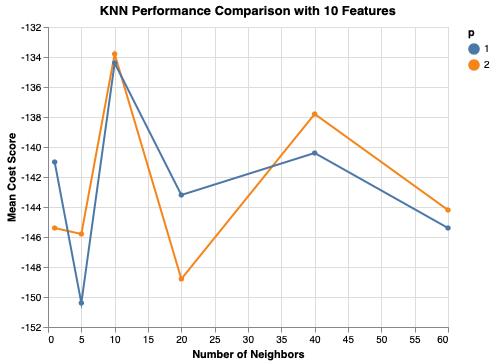

In [28]:
import altair as alt

results_KNN_10_features = results_KNN[results_KNN['rfi_fs__n_features_'] == 10.0]

alt.Chart(results_KNN_10_features, 
          title='KNN Performance Comparison with 10 Features'
         ).mark_line(point=True).encode(
    alt.X('knn__n_neighbors', title='Number of Neighbors'),
    alt.Y('mean_score', title='Mean Cost Score', scale=alt.Scale(zero=False)),
    alt.Color('knn__p:N', title='p')
)

## Decision Tree

The hyperparameter tuning for Decision Tree aim to determine the optimal combinations of `criterion` and maximum depth (`max_depth`).

In [29]:
from sklearn.tree import DecisionTreeClassifier 

pipe_DT = Pipeline(steps = [('rfi_fs', RFIFeatureSelector()),
                    ('dt', DecisionTreeClassifier())
                    ])

para_pipe_DT = {'rfi_fs__n_features_': [10, 20, 30, Data.shape[1]],
               'dt__max_depth': list(range(3,11)),
               'dt__criterion': ['gini', 'entropy']}
                    
gs_pipe_DT = GridSearchCV(estimator = pipe_DT,
                         param_grid = para_pipe_DT, 
                         cv = cv_method,
                         refit = True,
                         scoring = cost_score,
                         verbose = 1)


In [30]:
gs_pipe_DT.fit(D_train, t_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:   30.1s finished
/Users/ivylin/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=43, shuffle=False),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('rfi_fs',
                                        RFIFeatureSelector(n_features_=10)),
                                       ('dt',
                                        DecisionTreeClassifier(class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features=None,
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impurity_spli...
                                                               min_weight_fra

In [31]:
gs_pipe_DT.best_params_

{'dt__criterion': 'gini', 'dt__max_depth': 9, 'rfi_fs__n_features_': 59}

In [32]:
gs_pipe_DT.best_score_

-128.79542203147352

The optimal DT model shows the cost metrix score of -129. The best performing DT selected 59 features with gini criterion and maximun depth = 9.

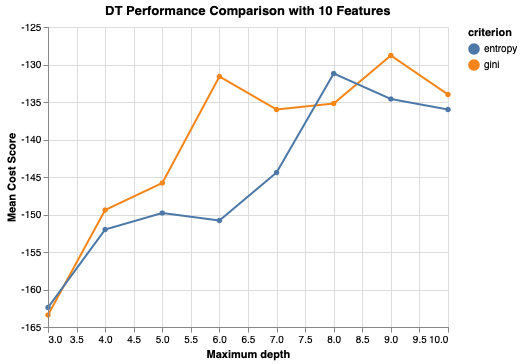

In [33]:
results_DT = get_search_results(gs_pipe_DT)

results_DT_10_features = results_DT[results_DT['rfi_fs__n_features_'] == 59.0]

alt.Chart(results_DT_10_features, 
          title='DT Performance Comparison with 10 Features'
         ).mark_line(point=True).encode(
    alt.X('dt__max_depth', title='Maximum depth'),
    alt.Y('mean_score', title='Mean Cost Score', scale=alt.Scale(zero=False)),
    alt.Color('dt__criterion:N', title='criterion')
)

In [58]:
results_DT = get_search_results(gs_pipe_DT)
results_DT.head()

,mean_score,std_score,max_score,min_score,dt__criterion,dt__max_depth,rfi_fs__n_features_
27,-128.8,5.11468,-120,-135,gini,9,59
55,-131.2,14.4693,-107,-144,entropy,8,59
15,-131.6,7.63151,-123,-143,gini,6,59
28,-131.6,21.6942,-91,-148,gini,10,10
31,-134,10.0598,-115,-145,gini,10,59


According to the table above, the decision tree model with only 10 features selected (mean score = -132) is almost as good as the one use 59 features (mean score = -129).    

### Further Parameter Tuning
We observe the optimal value of maximum depth hyperparameter is at the end of search space. Therefore, we try a higher value to make sure that we don't miss any better output.  

In [52]:
pipe_DT_2 = Pipeline(steps = [('rfi_fs', RFIFeatureSelector()),
                    ('dt', DecisionTreeClassifier())
                    ])

para_pipe_DT_2 = {'rfi_fs__n_features_': [10, 20, 30, Data.shape[1]],
               'dt__max_depth': list(range(3,31)),
               'dt__criterion': ['gini', 'entropy']}
                    
gs_pipe_DT_2 = GridSearchCV(estimator = pipe_DT_2,
                         param_grid = para_pipe_DT_2, 
                         cv = cv_method,
                         refit = True,
                         scoring = cost_score,
                         verbose = 1)

gs_pipe_DT_2.fit(D_train, t_train)

Fitting 5 folds for each of 224 candidates, totalling 1120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1120 out of 1120 | elapsed:  1.8min finished
/Users/ivylin/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=43, shuffle=False),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('rfi_fs',
                                        RFIFeatureSelector(n_features_=10)),
                                       ('dt',
                                        DecisionTreeClassifier(class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features=None,
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impurity_spli...
                                                               splitter='best

In [53]:
gs_pipe_DT_2.best_params_

{'dt__criterion': 'gini', 'dt__max_depth': 22, 'rfi_fs__n_features_': 59}

In [54]:
gs_pipe_DT_2.best_score_

-121.39628040057225

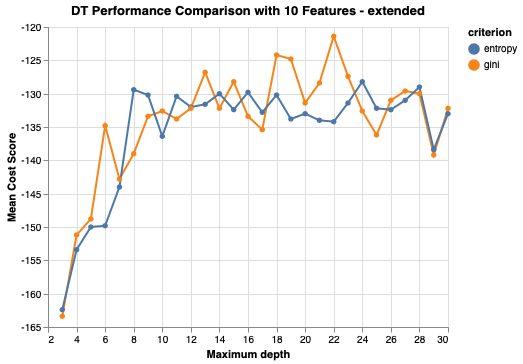

In [55]:
results_DT_2 = get_search_results(gs_pipe_DT_2)

results_DT_2_10_features = results_DT_2[results_DT_2['rfi_fs__n_features_'] == 59.0]

alt.Chart(results_DT_2_10_features, 
          title='DT Performance Comparison with 10 Features - extended'
         ).mark_line(point=True).encode(
    alt.X('dt__max_depth', title='Maximum depth'),
    alt.Y('mean_score', title='Mean Cost Score', scale=alt.Scale(zero=False)),
    alt.Color('dt__criterion:N', title='criterion')
)

After extending the search boundary, the Decision Tree gives a beter result with cost score = -121. It selects 59 features with gini split criterion and maximun depth of the tree = 22. 

## Naive Bayes (NB)

We adopt a Gaussian Naive Bayes model, since we have features with multi-classes. In hyperparameter tuning, we optimize `var_smoothing` (a variant of Laplace smoothing) as we do not have any prior. We conduct the grid search in the `logspace` (over the powers of 10) from `NumPy`. The search space starts from 10 to $10^{-3}$ with 200 different values, but we perform a random search over only 20 different values (for shorter run times). 
Since NB has strong normality assumption that each descriptive feature to follow a Gaussian distribution, we will first perform a power transformation before fitting model.

In [43]:
from sklearn.preprocessing import PowerTransformer
Data_transformed = PowerTransformer().fit_transform(D_train)

In [51]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RandomizedSearchCV

pipe_NB = Pipeline(steps = [('rfi_fs', RFIFeatureSelector()),
                           ('nb', GaussianNB())])

para_pipe_NB = {'rfi_fs__n_features_': [10, 20, 30, Data.shape[1]],
               'nb__var_smoothing': np.logspace(1,-3,num = 200)}

n_iter_search = 20

gs_pipe_NB = RandomizedSearchCV(estimator = pipe_NB,
                               param_distributions= para_pipe_NB, 
                               cv = cv_method, 
                               refit = True,
                               n_jobs = 2,
                               scoring = cost_score,
                               n_iter = n_iter_search,
                               verbose = 1)

gs_pipe_NB.fit(D_train, t_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  58 tasks      | elapsed:    4.3s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    6.5s finished
/Users/ivylin/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=43, shuffle=False),
                   error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('rfi_fs',
                                              RFIFeatureSelector(n_features_=10)),
                                             ('nb',
                                              GaussianNB(priors=None,
                                                         var_smoothing=1e-09))],
                                      verbose=False),
                   iid='warn', n_iter=20, n_jobs=2,
                   param_distributions={'nb__var_smoothing': array([1.0000000...
       1.66381689e-03, 1.58856513e-03, 1.51671689e-03, 1.44811823e-03,
       1.38262217e-03, 1.32008840e-03, 1.26038293e-03, 1.20337784e-03,
       1.14895100e-03, 1.09698580e-03, 1.04737090e-03, 1.00000000e-03]),
                                        'rfi_fs__n_features_': [10, 20

In [56]:
gs_pipe_NB.best_params_

{'rfi_fs__n_features_': 59, 'nb__var_smoothing': 0.009658832241158698}

In [59]:
gs_pipe_NB.best_score_

-109.06008583690988

In [61]:
results_NB = get_search_results(gs_pipe_NB)
results_NB.head()

,mean_score,std_score,max_score,min_score,rfi_fs__n_features_,nb__var_smoothing
3,-109.0,29.577018,-67.0,-150.0,59.0,0.009659
14,-111.6,21.777052,-84.0,-141.0,59.0,0.117585
12,-113.0,6.418723,-105.0,-122.0,10.0,0.013987
10,-113.8,15.380507,-97.0,-142.0,30.0,0.002643
6,-113.8,6.112283,-105.0,-122.0,10.0,0.018464


The Naive Bayes model provide the best score among the three models with cost score = -109.

#### Visualizing the search results.

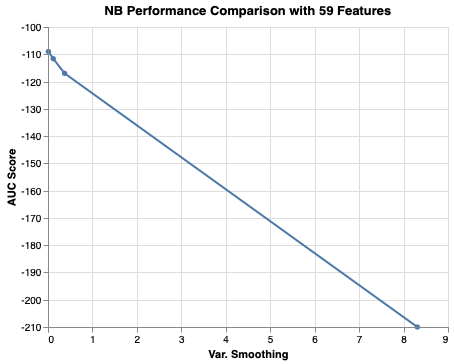

In [65]:
results_NB_10_features = results_NB[results_NB['rfi_fs__n_features_'] == 59.0]

alt.Chart(results_NB_10_features, 
          title='NB Performance Comparison with 59 Features'
         ).mark_line(point=True).encode(
    alt.X('nb__var_smoothing', title='Var. Smoothing'),
    alt.Y('mean_score', title='AUC Score', scale=alt.Scale(zero=False))
)

# Performance Evaluation

We have optimized the hyper-parameters for the three classifiers using the training data. Now, we are going to fit the optimized models on the test data using cross validation. To determine the best model, we perform pairwise t-tests to test if the difference between the performance of any two classifiers is statistically significant. Firstly, we perform 10-fold stratified cross-validation on each best model (without any repetitions). Second, we conduct a paired t-test for the AUC score between the following model combinations:

* KNN vs. DT,
* KNN vs. NB,
* DT vs. NB.

In [72]:
from sklearn.model_selection import cross_val_score

cv_method_ttest = StratifiedKFold(n_splits=10, random_state=123)

cv_results_KNN = cross_val_score(estimator=gs_pipe_KNN.best_estimator_,
                                 X=D_test,
                                 y=t_test, 
                                 cv=cv_method_ttest, 
                                 n_jobs=-2,
                                 scoring= cost_score)
print ( 'KNN cost score: ' , cv_results_KNN.mean() )

KNN cost score:  -28.1


In [73]:
cv_results_DT = cross_val_score(estimator=gs_pipe_DT_2.best_estimator_,
                                X=D_test,
                                y=t_test, 
                                cv=cv_method_ttest, 
                                n_jobs=-2,
                                scoring= cost_score)

print ( 'DT cost score: ' , cv_results_DT.mean() )

DT cost score:  -31.8


In [74]:
Data_test_transformed = PowerTransformer().fit_transform(D_test)

cv_results_NB = cross_val_score(estimator=gs_pipe_NB.best_estimator_,
                                X=Data_test_transformed,
                                y=t_test, 
                                cv=cv_method_ttest, 
                                n_jobs=-2,
                                scoring= cost_score)

print ( 'NB cost score: ' , cv_results_NB.mean())

NB cost score:  -16.4


Since we fixed the same random state to be same during cross-validation, all classifiers were fitted and then tested on exactly the same test data partitions. We use the stats.ttest_rel function from the SciPy module to run the following t-tests on test data.

In [77]:
from scipy import stats

print(stats.ttest_rel(cv_results_KNN, cv_results_DT))
print(stats.ttest_rel(cv_results_KNN,cv_results_NB))
print(stats.ttest_rel(cv_results_DT, cv_results_NB))

Ttest_relResult(statistic=1.5953480192808793, pvalue=0.14509879995342212)
Ttest_relResult(statistic=-3.9740376520086103, pvalue=0.003234826550168032)
Ttest_relResult(statistic=-3.9350870435896095, pvalue=0.0034314450621176474)


Based on the statistical test, the performance of Naive Bayes has significant difference with both KNN and Decision Tree at a 95% significance level. We conclude that Naive Bayes is statistically the best model in terms of the cost matrix on the test set.    



Although this data requires a specific cost matrix, it would be beneficial to see other evaluation metrics. 

In [79]:
pred_KNN = gs_pipe_KNN.predict(D_test)

Data_test_transformed = PowerTransformer().fit_transform(D_test)

pred_NB = gs_pipe_NB.predict(Data_test_transformed)

pred_DT = gs_pipe_DT_2.predict(D_test)


from sklearn import metrics
print("\nClassification report for K-Nearest Neighbor") 
print(metrics.classification_report(t_test, pred_KNN))

print("\nClassification report for Decision Tree") 
print(metrics.classification_report(t_test, pred_DT))

print("\nClassification report for Naive Bayes") 
print(metrics.classification_report(t_test, pred_NB))


Classification report for K-Nearest Neighbor
              precision    recall  f1-score   support

           0       0.51      0.37      0.43        90
           1       0.76      0.85      0.80       210

    accuracy                           0.70       300
   macro avg       0.63      0.61      0.61       300
weighted avg       0.68      0.70      0.69       300


Classification report for Decision Tree
              precision    recall  f1-score   support

           0       0.44      0.48      0.46        90
           1       0.77      0.74      0.75       210

    accuracy                           0.66       300
   macro avg       0.60      0.61      0.60       300
weighted avg       0.67      0.66      0.66       300


Classification report for Naive Bayes
              precision    recall  f1-score   support

           0       0.39      0.79      0.52        90
           1       0.84      0.47      0.60       210

    accuracy                           0.56       300
  

Since this data is regarding to credit prediction, **false positive** result, that is predicting a bad customer as good is much worse than classifying a good one as bad. Therefore, we shall look at the Precision on the positive target. In the classification report, Naive Bayes still outperform there other models, which aligns with our finding using the customized cost matrix.

# Limitations

Our modelling process has some limitations. First of all, we rank and select the model solely on its predictive performance. In the real world, model interpretability and explainability also play an important role in business context. We may need to take those factors into account in the future.   

Also, as this data set does not meet the normality assumption in Naive Bayes model, we utilized a blanket power transformation on the whole training data. A better solution is to build a Gaussian NB and a Bernoulli NB separately on the numerical and dummy descriptive features separately. 

# Conclusion 

In this credit classification task, credit amount, age and duration are found to be the most important features based on Random Forest Importance (RFI). For modeling, the Naive Bayes model with 59 features selected RFI provides the best cost score on both of the the training and test data. However, our final model does not actually benefits from feature selection process as the model with optimal parameters selects all fatures in the training set. If the data set scale up in the future, we shall see feature selection has greater effect on the modelling process.

# References

* Kelleher, John D., author, Mac Namee, Brian, & D'Arcy, Aoife. (2015). *Fundamentals of machine learning for predictive data analytics : Algorithms, worked examples, and case studies.* Cambridge, Massachusetts: The MIT Press.


* Hofmann H. (1994), UCI Machine Learning Repository: Statlog (German Credit Data) Data Set. Available at https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data) [Accessed 2019-04-20]


* Scikit-learn machin learning in Python. https://scikit-learn.org [Accessed 2019-05-26]